In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [280]:
from tqdm import tqdm_notebook
from joblib import Parallel,delayed,effective_n_jobs

In [281]:
import pymorphy2
import nltk

In [4]:
assistant_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
assistant_table = list(assistant_table)
assistant_table[0].keys()

dict_keys(['yang_assignments_repeat_1', 'mds_key', 'linguists_sugested_text', 'toloka_text', '_other', 'check_in_yang_results', 'toloka_assignments_repeat_5_with_chorus_and_pitch', 'toloka_assignments_repeat_9_selected_workers_with_chorus_and_pitch', 'date', 'number_of_speakers', 'toloka_assignments_repeat_4_with_bend', 'text', 'raw_text_linguists', 'linguists_comment', 'toloka_assignments_repeat_3_with_pitch', 'toloka_number_of_speakers', 'toloka_assignments_repeat_6_with_chorus', 'toloka_assignments_repeat_1', 'toloka_assignments_repeat_7_with_chorus_and_pitch', 'toloka_assignments_repeat_8_selected_workers_with_chorus_and_pitch', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'toloka_assignments_repeat_11_selected_workers_with_pitch', 'toloka_assignments', 'toloka_assignments_repeat_10', 'toloka_assignments_repeat_2_with_pitch', 'audio', 'url'])

In [5]:
quasar_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/quasar-general_with_spotter_ideal_annotations_2019-04-18__2019-04-24"
)
quasar_table = list(quasar_table)
quasar_table[0].keys()

dict_keys(['mds_key', 'linguists_sugested_text', 'toloka_text', 'toloka_assignments_repeat_2_with_chorus_and_pitch', 'spotter_tail_trim', 'toloka_assignments_repeat_4_selected_workers_with_pitch', '_other', 'check_in_yang_results', 'spotter_mds_key', 'date', 'number_of_speakers', 'text', 'downloadUrl', 'toloka_assignments_repeat_3_selected_workers_with_chorus_and_pitch', 'spotter_max_length', 'raw_text_linguists', 'linguists_comment', 'toloka_number_of_speakers', 'mdsFileName', 'toloka_assignments_repeat_1', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'url_in_first_toloka', 'asr_mds_key', 'toloka_assignments', 'audio', 'url', 'initialFileName'])

## TODO: протестировать след. подход:
y = 1, если все предложение совпало или только одно слово заменено знаком вопроса 

In [327]:
data = []
data_with_spell_corr = []
for row in assistant_table:
    for assignment in row['toloka_assignments_repeat_11_selected_workers_with_pitch']:
        new_row = dict()
        for key in ('speech', 'submit_ts', 'text', 'number_of_speakers', 'worker_id'):
            new_row[key] = assignment[key]
        new_row['is_right'] = 1 if row['text'] == assignment['text'] else 0
        new_row['mark'] = row['mark']
        new_row['assistant'] = 1
        data.append(new_row)
        data_with_spell_corr.append(new_row.copy())
for row in quasar_table:
    for assignment in row['toloka_assignments_repeat_4_selected_workers_with_pitch']:
        new_row = dict()
        for key in ('speech', 'submit_ts', 'text', 'number_of_speakers', 'worker_id'):
            new_row[key] = assignment[key]
        new_row['is_right'] = 1 if row['text'] == assignment['text'] else 0
        new_row['mark'] = row['mark']
        new_row['assistant'] = 0
        data.append(new_row)
        data_with_spell_corr.append(new_row.copy())
data = pd.DataFrame(data)
data_with_spell_corr = pd.DataFrame(data_with_spell_corr)
data.sample(5)

,assistant,is_right,mark,number_of_speakers,speech,submit_ts,text,worker_id
30299,1,1,TEST,one,OK_one_speaker,1568947551028,найди мне фотографию шмотова леонида,05616ccdbce241371a9bad9171d9134d
58365,1,0,TRAIN,one,OK_one_speaker,1568963825288,а ты спать на будешь,a11e4da437787d817a2b5851f068bd95
65125,1,1,TRAIN,None,BAD,1568958112363,,ba1a1e2fa25e12cf624fcd9a020768e9
82877,0,1,TRAIN,one,OK_one_speaker,1568736572402,алиса погода,4630687e515265b691e57f2d03831a29
95840,0,1,TEST,one,OK_one_speaker,1568742437498,алиса алиса продолжить слушать,f553952d6837dbd335a3309dbe018924


In [88]:
categorical_columns = ['assistant', 'number_of_speakers', 'speech', 'worker_id']
target_column = 'is_right'

In [194]:
data[categorical_columns] = data[categorical_columns].fillna('NaN')

In [282]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

def fix_misspellings(text):
    headers = {
        'Connection': 'close'
    }
    params={
        'text':text,
        'lang':'ru',
        'options':'512',
    }
    s = requests.Session()
    retries = Retry(total=10, backoff_factor=1, status_forcelist=[ 502, 503, 504 ])
    s.mount('http://', HTTPAdapter(max_retries=retries))
    try:
        resp=s.get('https://speller.yandex.net/services/spellservice.json/checkText',params=params,headers=headers)
        resp=resp.json()
    except ValueError:
        print(resp)
    if not resp:
        return text
    first_pos=0
    new_text=[]
    for fix in resp:
        new_text.append(text[first_pos:fix['pos']].strip())
        new_text.append(fix['s'][0].strip())
        first_pos=fix['pos']+fix['len']
    new_text.append(text[first_pos:].strip())
    return ' '.join(new_text).strip()

In [310]:
def process_entry(entry):
    new_entry = entry
    new_entry['text']=fix_misspellings(new_entry['text'].lower().replace('ё', 'е'))
    return new_entry

In [315]:
out = [process_entry(row) for i, row in data.iterrows() if i < 10]

In [330]:
data_with_spell_corr = pd.DataFrame(Parallel(n_jobs=effective_n_jobs(),
                                           batch_size=10)(delayed(process_entry)(entry) 
                                                                             for i, entry in tqdm_notebook(data_with_spell_corr.iterrows())))

In [332]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
morph = pymorphy2.MorphAnalyzer()

data['text'] = data['text'].apply(lambda x: ' '.join(tokenizer.tokenize(x.lower())))
data['text'] = data['text'].apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))

data_with_spell_corr['text'] = data_with_spell_corr['text'].apply(lambda x: ' '.join(tokenizer.tokenize(x.lower())))
data_with_spell_corr['text'] = data_with_spell_corr['text'].apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))

In [333]:
print("Tokenized:")
data["text"][2::30000]

Tokenized:


2                                  
30002                              
60002                   купить слон
90002                    алиса стоп
120002    алиса выключить будильник
Name: text, dtype: object

In [334]:
print("Fixed and tokenized:")
data_with_spell_corr["text"][3::30000]

Fixed and tokenized:


3                                  
30003                              
60003                   купить слон
90003                    алиса стоп
120003    алиса выключить будильник
Name: text, dtype: object

In [53]:
# Count how many times does each token occur in "title" in total
# build a dictionary { token -> its count }
from collections import Counter

token_counts = Counter()
for row in data.text:
    for word in row.split():
        token_counts[word] += 1

In [335]:
token_counts_with_spell_corr = Counter()
for row in data_with_spell_corr.text:
    for word in row.split():
        token_counts_with_spell_corr[word] += 1

In [54]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 12754
('алиса', 67437)
('включить', 15714)
('я', 11367)
('ты', 10891)
('?', 9608)
...
('семдесить', 1)
('влючаять', 1)
('профонация', 1)


In [336]:
print("Total unique tokens :", len(token_counts_with_spell_corr))
print('\n'.join(map(str, token_counts_with_spell_corr.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts_with_spell_corr.most_common()[-3:])))

Total unique tokens : 10568
('алиса', 67460)
('включить', 15741)
('я', 11370)
('ты', 10892)
('?', 9708)
...
('поддевать', 1)
('moove', 1)
('gull', 1)


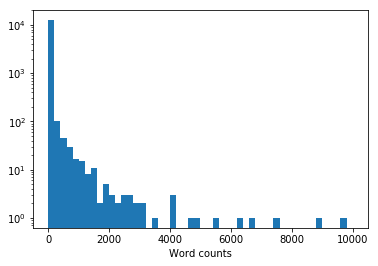

In [55]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [339]:
min_count = 2

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [key for key, value in token_counts.items() if value >= min_count]

In [340]:
tokens_with_spell_corr = [key for key, value in token_counts_with_spell_corr.items() if value >= min_count]

In [65]:
# Add a special tokens for unknown and empty words
UNK, PAD = "?", "PAD"
tokens = [PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert UNK in tokens
print("Correct!")

Vocabulary size: 8431
Correct!


In [341]:
# Add a special tokens for unknown and empty words
UNK, PAD = "?", "PAD"
tokens_with_spell_corr = [PAD] + sorted(tokens_with_spell_corr)
print("Vocabulary size:", len(tokens_with_spell_corr))

assert type(tokens_with_spell_corr) == list
assert UNK in tokens_with_spell_corr
print("Correct!")

Vocabulary size: 8125
Correct!


In [66]:
token_to_id = {token: index for index, token in enumerate(tokens)}
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


In [221]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
#     max_len = 287
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [197]:
print("Lines:")
print('\n'.join(data["text"][::30000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["text"][::30000]))

Lines:


купить слон
алиса стоп
алиса выключить будильник

Matrix:
[[   0    0    0]
 [   0    0    0]
 [3786 6802    0]
 [1074 7082    0]
 [1074 2035 1572]]


In [72]:
workers_count = Counter()
for worker in data['worker_id']:
    workers_count[worker] += 1
print("Total unique workers :", len(workers_count))
print('\n'.join(map(str, workers_count.most_common(n=5))))
print('...')
print('\n'.join(map(str, workers_count.most_common()[-3:])))

Total unique workers : 318
('9acb2529197c9c95d4b76dd386162dff', 2704)
('4630687e515265b691e57f2d03831a29', 2641)
('b8f74c8c902210e525c156bdb768f704', 1976)
('576f30216cefc6149e669b5a4bdb5308', 1976)
('3929d7c950991930645617d8b6ae7aa6', 1950)
...
('487be1e67fe75fa65b824f17ccb110e8', 26)
('1ffbf3b8d78711e32b8c3472b2089347', 26)
('c1049fa91bf8aac42dab3f08407374f5', 26)


In [198]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent worker to minimize memory usage
top_workers, top_counts = zip(*Counter(data['worker_id']).most_common(3000))
recognized_workers = set(top_workers)
data['worker_id'] = data['worker_id'].apply(lambda comp: comp if comp in recognized_workers else "other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

In [200]:
data_train = data[data['mark'] == 'TRAIN']
data_val = data[data['mark'] == 'TEST']
data_train = data_train.drop(columns=['mark'])
data_val = data_val.drop(columns=['mark'])
data_train.shape, data_val.shape

((71650, 7), (71370, 7))

In [199]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'text' : int64[batch, t_max_len]
    """
    batch = {}
    batch["text"] = as_matrix(data["text"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["text"] = apply_word_dropout(batch["text"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [255]:
make_batch(data_train[:-3], max_len=20)

{'text': array([[ 944, 7913, 8382, ...,    0,    0,    0],
        [7913, 8382, 7531, ...,    0,    0,    0],
        [7913, 8382, 7531, ...,    0,    0,    0],
        ...,
        [1074, 3114,    0, ...,    0,    0,    0],
        [1074, 3114,    0, ...,    0,    0,    0],
        [1074, 3114,    0, ...,    0,    0,    0]], dtype=int32),
 'Categorical': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'is_right': array([0, 1, 1, ..., 1, 1, 1])}

In [109]:
import keras
import keras.layers as L
import tensorflow as tf
from sklearn.metrics import roc_auc_score

In [264]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    if curr_session is not None:
        curr_session.close()
    K.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [110]:
def roc_auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [266]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
    """ Build a model that maps three data sources to a single linear output: predicted is_right"""
    
    l_text = L.Input(shape=[None], name="text")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    l_text_embedding = L.Embedding(input_dim=len(tokens), output_dim=80, input_length=7)(l_text)
    l_text_conv = L.Conv1D(128, 3)(l_text_embedding)
    l_text_act = L.Activation("relu")(l_text_conv)
    l_text_pool = L.GlobalMaxPool1D()(l_text_act)
    l_text_pool_act = L.Activation("relu")(l_text_pool)
    
    l_text_embedding_2 = L.Embedding(input_dim=len(tokens), output_dim=40,  input_length=10)(l_text)
    l_text_conv_2 = L.Conv1D(128, 5)(l_text_embedding_2)
    l_text_act_2 = L.Activation("relu")(l_text_conv_2)
    l_text_pool_2 = L.GlobalMaxPool1D()(l_text_act_2)
    l_text_pool_act_2 = L.Activation("relu")(l_text_pool_2)
    
    merged = L.Concatenate()([l_text_pool_act, l_text_pool_act_2])
    merged_normed = L.BatchNormalization()(merged)
    
    preout = L.Dense(128)(L.Activation("relu")(merged_normed))
    
    output_layer = L.Dense(1)(L.Activation("softmax")(L.Dense(128)(L.Activation("relu")(preout))))
    
    model = keras.models.Model(inputs=[l_text, l_categ], outputs=[output_layer])
    model.compile('adam', 'binary_crossentropy', metrics=['binary_crossentropy', 'binary_accuracy', roc_auc])
    return model

In [269]:
s = reset_tf_session()
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['is_right'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 7, 80)        674480      text[0][0]                       
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 10, 40)       337240      text[0][0]                       
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 128)       30848       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (

In [250]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [160]:
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

In [268]:
import keras.backend as K
K.clear_session()

Epoch 1/20
40/40 [==============================] - 21s 514ms/step - loss: 1.6216 - binary_crossentropy: 1.6216 - binary_accuracy: 0.2859 - roc_auc: 0.4918 - val_loss: 1.0701 - val_binary_crossentropy: 1.0701 - val_binary_accuracy: 0.2870 - val_roc_auc: 0.5625
Epoch 2/20
40/40 [==============================] - 20s 501ms/step - loss: 1.1093 - binary_crossentropy: 1.1093 - binary_accuracy: 0.2841 - roc_auc: 0.6067 - val_loss: 0.9706 - val_binary_crossentropy: 0.9706 - val_binary_accuracy: 0.2868 - val_roc_auc: 0.5447
Epoch 3/20
40/40 [==============================] - 20s 502ms/step - loss: 0.9806 - binary_crossentropy: 0.9806 - binary_accuracy: 0.2916 - roc_auc: 0.6311 - val_loss: 0.8493 - val_binary_crossentropy: 0.8493 - val_binary_accuracy: 0.2870 - val_roc_auc: 0.5714
Epoch 4/20
40/40 [==============================] - 20s 503ms/step - loss: 0.8865 - binary_crossentropy: 0.8865 - binary_accuracy: 0.2928 - roc_auc: 0.6739 - val_loss: 0.7642 - val_binary_crossentropy: 0.7642 - val_bi

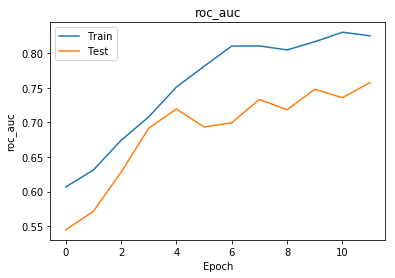

In [270]:
batch_size = 256
epochs = 20
steps_per_epoch = 40 #(len(data_train) - 1) // batch_size + 1  #for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

history = model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0), 
                              epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                              validation_steps=data_val.shape[0] // batch_size,
                              callbacks=[tensorboard,
                                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)])

plt.plot(history.history['roc_auc'][1:])
plt.plot(history.history['val_roc_auc'][1:])
plt.title('roc_auc')
plt.ylabel('roc_auc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

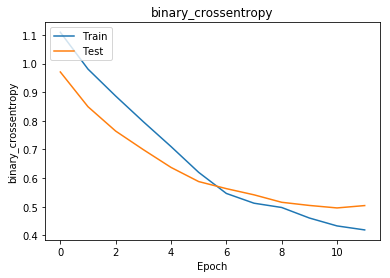

In [272]:
plt.plot(history.history['binary_crossentropy'][1:])
plt.plot(history.history['val_binary_crossentropy'][1:])
plt.title('binary_crossentropy')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [258]:
def explain(model, sample, col_name='text'):
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token, max_len=287))[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [259]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [278]:
i = 96450
tokens_and_weights = explain(model, data.loc[i], "text")
draw_html([(tok, weight * 20) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

ты зависнуть

In [261]:
data[(data.text != '') & (len(data.text) > 30)].sample(10)

,assistant,is_right,mark,number_of_speakers,speech,submit_ts,text,worker_id
122264,0,1,TRAIN,one,OK_one_speaker,1568736488432,стоп,62b6186f8b81aa9c5efbb6495536b3d4
105442,0,1,TEST,one,OK_one_speaker,1568749076461,алиса сколько в русский язык матный слово,ba1a1e2fa25e12cf624fcd9a020768e9
126521,0,1,TRAIN,one,OK_one_speaker,1568733690687,это же вредный,4d6284b06f643ce7180a7491edc0f612
111914,0,1,TEST,one,OK_one_speaker,1568743219686,алиса главный меню,9acb2529197c9c95d4b76dd386162dff
7351,1,0,TEST,one,OK_one_speaker,1568952417311,алиса сказать к что сниться ворон,622e74d469632e64dda1564fd63d2f67
96450,0,0,TEST,one,OK_one_speaker,1568748280182,ты зависнуть,78e3f83457bc261aa5a0ecb3b1eb4649
12857,1,0,TRAIN,one,OK_one_speaker,1568961877350,алиса джуна погода,b7d1dc5248c9445d74209d3c97b0e559
139261,0,1,TEST,one,OK_one_speaker,1568742444546,алиса включить первое видео,59a6ae65d9c937e1d9e57914fbdb815e
40645,1,1,TRAIN,one,OK_one_speaker,1568965286704,как быть по казахски мумия,100466fad0d62eeb08de41ce631f3acf
117382,0,1,TEST,one,OK_one_speaker,1568745877103,алиса погода сегодня,affe421f522f3903817238e73ca74af2
